In [147]:
# CSC 461 Final Project 

## Using CNN to classify images of military aircraft

In [ ]:
# import data handling tools
import numpy as np
import pandas as pd
import os
import random

import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from IPython.display import clear_output
from tqdm.notebook import trange, tqdm


In [149]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Set the default tensor type to CUDA tensors
    torch.set_default_device(torch.device("cuda"))
    device = torch.device("cuda")
    print(f"Running on {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print("Running on CPU")

Running on NVIDIA GeForce RTX 3070


In [150]:
# Define transformations for the training and testing sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load the dataset

#get current directory
base_dir = os.getcwd()

# add crop to the directory
base_dir = os.path.join(base_dir, 'crop')

dataset = ImageFolder(root=base_dir, transform=transform)

# Calculate the sizes of each dataset
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size

# Split the dataset
generator = torch.Generator(device='cuda')
print(device)
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size], generator=generator)

# Create data loaders
def get_data_loaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader

cuda


In [151]:
# see if sets are divided correctly

print(f"Number of training files: {train_size}")
print(f"Number of validation files: {valid_size}")
print(f"Number of test files: {test_size}")

Number of training files: 22593
Number of validation files: 4841
Number of test files: 4843


Random images from training set:


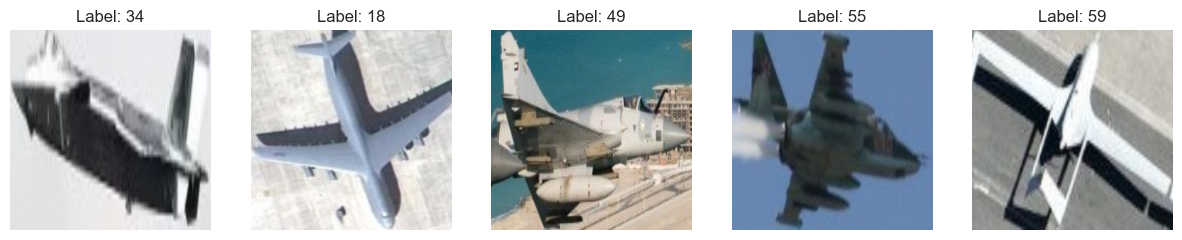

Random images from validation set:


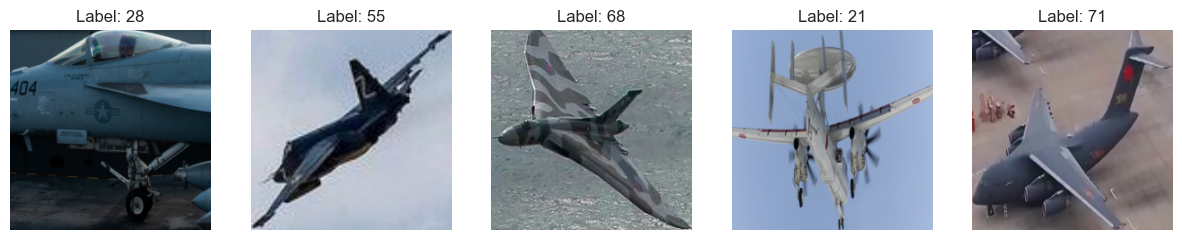

Random images from test set:


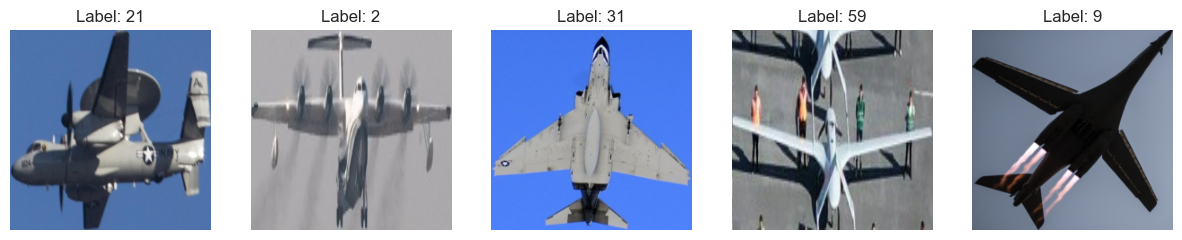

In [152]:
import random

# Function to show random images from a dataset
def show_random_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

# Show random images from each set
print("Random images from training set:")
show_random_images(train_dataset)

print("Random images from validation set:")
show_random_images(valid_dataset)

print("Random images from test set:")
show_random_images(test_dataset)

In [ ]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x





In [ ]:
# create a function to train the model